In [1]:
import os
import sys

cwd = os.getcwd()
pwd = cwd[:cwd.rfind('/')]
sys.path.append(pwd)

import numpy as np
import imgviz
import matplotlib.pyplot as plt

from dataloader import DatasetClean

/home/liao0090/miniconda3/envs/cvtorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
issave = False

## Ground truth

In [3]:
# Dataset
data_path = '../data/'
cln_dataset = DatasetClean(data_path)
labs = ['bckgrnd', 'person', 'bike', 'car', 'drone', 'boat', 'animal', 'obstacle', 'cnstn', 'plant', 'road', 'sky']
cmap = np.array([
        (  0,   0,   0),  #  Background
        (192, 128, 128),  #  Person
        (  0, 128,   0),  #  Bike
        (128, 128, 128),  #  Car
        (128,   0,   0),  #  Drone
        (  0,   0, 128),  #  Boat
        (192,   0, 128),  #  Animal
        (192,   0,   0),  #  Obstacle
        (192, 128,   0),  #  Construction
        (  0,  64,   0),  #  plant
        (128, 128,   0),  #  Road
        (  0, 128, 128)   #  Sky
    ])

def plot_rgb(img, label_img):
    # process rgb
    img_base = imgviz.color.rgb2gray(img)
    # labelviz = imgviz.label2rgb(label=label_img, image=img_base)
    labelviz = imgviz.label2rgb(
            label=label_img, image=img_base, 
            label_names=labs, colormap=cmap, font_size=25, loc="centroid"
        )
    return labelviz

(-0.5, 1279.5, 719.5, -0.5)

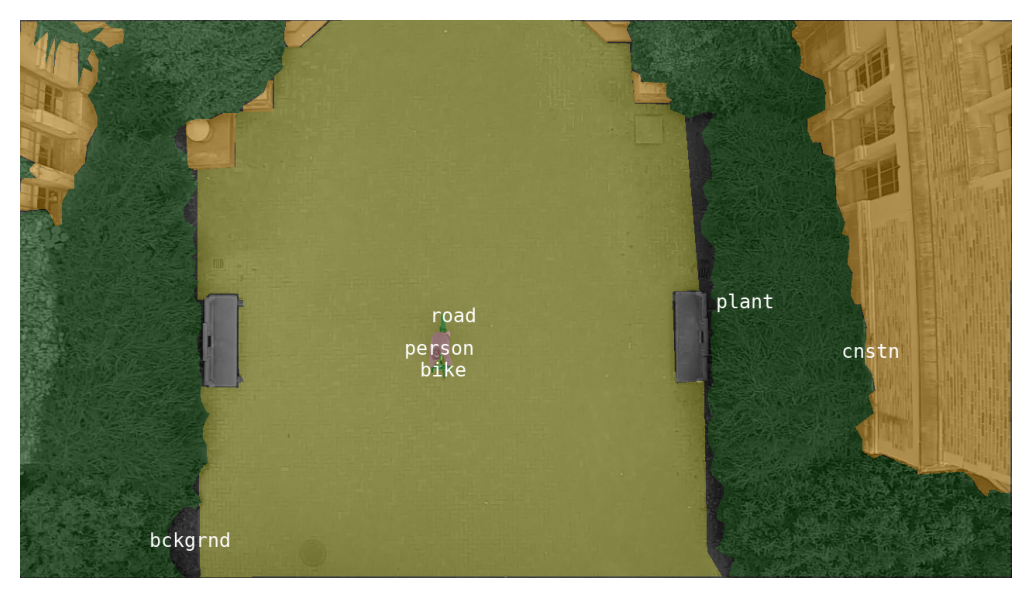

In [4]:
# get image
idx = 222
img, label_img = cln_dataset[idx]
img = img.astype('uint8')

plt.figure(dpi=200)
labelviz = plot_rgb(img, label_img)
plt.imshow(labelviz)
plt.axis("off")

## Model output

In [5]:
import torch
import torchvision.transforms as transforms
from model import *
from dataloader import DatasetVal
from logger import Logger, ModelLogger

In [6]:
mname = 'deeplabv3'
lname = 'focalloss'
flag = '1114'
flag_run = "{}_{}".format(lname, flag)
logger = Logger(save_path='../saved_models/', prj_name=mname, flag_run=flag_run)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def restore_model(mname, logger):
    assert logger.path_existed, f"Path {logger.dir_save} not found"
    model_logger = ModelLogger(logger, state_only=True)
    model_logger.metric_name = 'iou'

    # ===== Model =====
    model = get_model(mname)
    model = model_logger.load_model('best', model=model).to(device)
    model.eval()
    return model

In [7]:
# load dataset and model
val_dataset = DatasetVal('../data/')
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=1)
cln_dataloader = torch.utils.data.DataLoader(cln_dataset, batch_size=2, shuffle=False, num_workers=1)
model = restore_model(mname, logger)

In [8]:
# get image
idx = [222, 223]
xs, ys = [], []
for i in idx:
    x, y = val_dataset[i]
    xs.append(x)
    ys.append(y)
xs = torch.stack(xs)
ys = torch.stack(ys)

# get prediction
with torch.no_grad():
    pred_mask = model(xs.to(device))
pred_mask = torch.softmax(pred_mask, dim=1)
pred = torch.argmax(pred_mask, dim=1)
pred = pred.cpu()

# transfer to label map
h, w = pred.shape[1:]
pred = transforms.functional.crop(pred, 8, 0, h-16, w)

(-0.5, 1279.5, 719.5, -0.5)

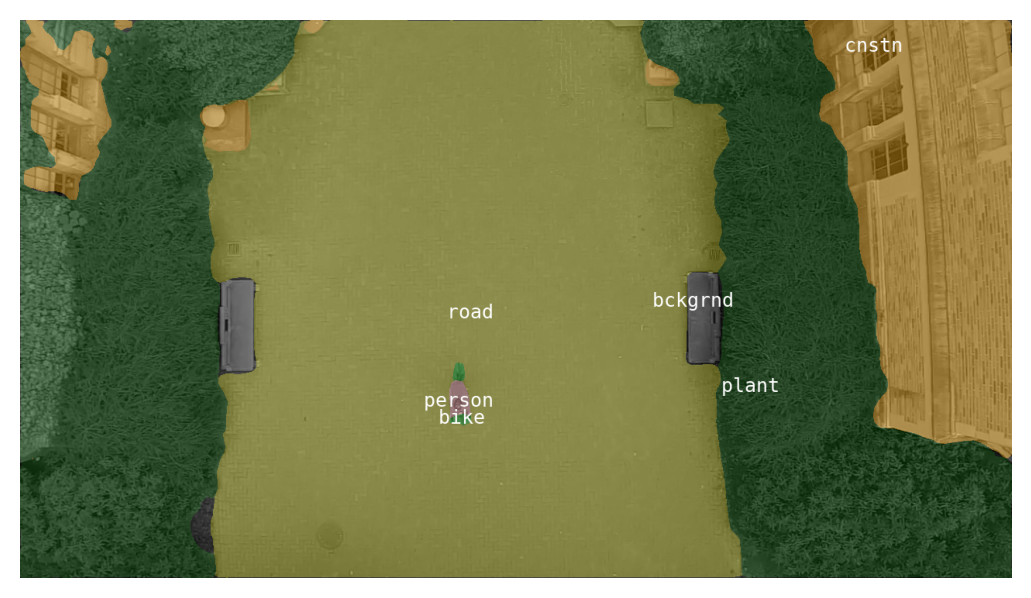

In [9]:
# get base image
batch_id = 1
img, _ = cln_dataset[idx[batch_id]]
img = img.astype('uint8')
label_pred = pred[batch_id].numpy()

plt.figure(dpi=200)
labelviz = plot_rgb(img, label_pred)
plt.imshow(labelviz)
plt.axis("off")